# News clustering with uci-news-aggregator.csv


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score


Read dataset and show the first 5 lines

In [2]:
dataset = pd.read_csv("C:/Users/Admin/Desktop/Machine Learning/News-aggregator.csv",nrows=10000)
dataset.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.394470e+12
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.394470e+12
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.394470e+12


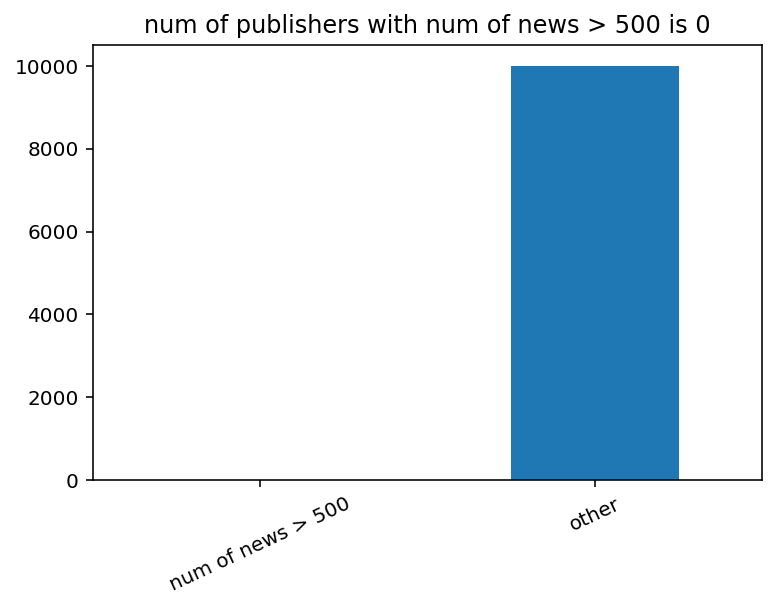

In [3]:
pubshare = dataset['PUBLISHER'].value_counts()
threshold = 500
mask = pubshare > threshold
x = pd.Series()
x[('num of news > %d' %threshold)] = pubshare.loc[mask].sum()
x['other'] = pubshare.loc[~mask].sum()
x.plot(kind = 'bar')
plt.xticks(rotation=25)
plt.title('num of publishers with num of news > %d is %d' %(threshold, mask.sum()))
plt.show()


In [4]:
pubshare

Reuters                            129
Examiner.com                       101
Wetpaint                            81
NASDAQ                              73
Contactmusic.com                    70
Wall Street Journal                 68
Huffington Post                     66
Businessweek                        66
San Francisco Chronicle             61
Los Angeles Times                   55
Forbes                              55
TheCelebrityCafe.com                46
Entertainmentwise                   43
Daily Mail                          43
International Business Times AU     42
GlobalPost                          42
Bloomberg                           41
International Business Times        39
TIME                                38
ValueWalk                           38
PerezHilton.com                     37
International Business Times UK     36
RTT News                            34
MarketWatch                         34
Reality TV World                    33
USA TODAY                

In [5]:
s = dataset['HOSTNAME'].value_counts()
for hostname in s.keys():
    target_website = dataset.loc[dataset['HOSTNAME'].isin([hostname])]
    vc = target_website['CATEGORY'].value_counts()
    if 'm' in vc:
        if vc['m'] > 500:
            print('Hostname: %s , %s' %(hostname, str(vc)))

In [6]:
dataset['CATEGORY'].unique()
s = dataset['HOSTNAME'].value_counts()
print(s.keys())
target_website = dataset.loc[dataset['HOSTNAME'].isin([r'www.contactmusic.com'])]
target_website
# item = (target_website.loc[dataset['ID'].isin(['8732'])])
# print(item)
# reuters = dataset.loc[dataset['PUBLISHER'].isin([r'Reuters'])]
# reuters = reuters.assign(C="")
# reuters.head()

Index(['www.examiner.com', 'in.reuters.com', 'www.wetpaint.com',
       'www.nasdaq.com', 'www.huffingtonpost.com', 'www.contactmusic.com',
       'www.businessweek.com', 'www.sfgate.com', 'www.forbes.com',
       'www.bizjournals.com',
       ...
       'blog.caranddriver.com', 'www.news-record.com', 'www.biztimes.com',
       'www.americanlawyer.com', 'www.tntmagazine.com',
       'www.mayerthorpefreelancer.com', 'www.techdigest.tv',
       'www.inlandnewstoday.com', 'msn.foxsports.com', 'www.planetary.org'],
      dtype='object', length=2544)


,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
2274,2275,"Latest ""Game Of Thrones"" Trailer Reveals Nothi...",http://www.contactmusic.com/article/game-of-th...,Contactmusic.com,e,doklLt-bdL5ggOMQ_e6SbdaJYJr5M,www.contactmusic.com,1.394520e+12
2420,2421,Lindsay Lohan - Lindsay Lohan wants 'integrity',http://www.contactmusic.com/story/lindsay-loha...,Contactmusic.com,e,d-j0NxvRU7t3t8M-vJ--LXhVdVkvM,www.contactmusic.com,1.394520e+12
2428,2429,Lindsay Lohan Spends Most Of OWN Pilot Cooling...,http://www.contactmusic.com/article/lindsay-lo...,Contactmusic.com,e,d-j0NxvRU7t3t8M-vJ--LXhVdVkvM,www.contactmusic.com,1.394520e+12
2455,2456,Miley Cyrus' Obsessed Fan Sneaks Into Singer's...,http://www.contactmusic.com/article/miley-cyru...,Contactmusic.com,e,dQ7mGX5Q5MsdjmMycY3sCTlY_y57M,www.contactmusic.com,1.394520e+12
2470,2471,Miley Cyrus - Miley Cyrus fan arrested after s...,http://www.contactmusic.com/story/miley-cyrus-...,Contactmusic.com,e,dQ7mGX5Q5MsdjmMycY3sCTlY_y57M,www.contactmusic.com,1.394520e+12
2473,2474,Miley Cyrus - Teen Arrested After Sneaking Int...,http://www.contactmusic.com/story/teen-arreste...,Contactmusic.com,e,dQ7mGX5Q5MsdjmMycY3sCTlY_y57M,www.contactmusic.com,1.394520e+12
2681,2682,"Tensions Run High Ahead Of ""Bachelor"" Finale (...",http://www.contactmusic.com/article/the-bachel...,Contactmusic.com,e,dHmpog6unxaYYaMzYMEdbkeDeB9iM,www.contactmusic.com,1.394530e+12
2887,2888,Zac Efron Confirms He Is Eager For 'High Schoo...,http://www.contactmusic.com/article/zac-efron-...,Contactmusic.com,e,dEwcrt6LPSpnQZMj6PUU87nPXmo7M,www.contactmusic.com,1.394530e+12
2893,2894,Zac Efron - Zac Efron Open To High School Musi...,http://www.contactmusic.com/story/zac-efron-op...,Contactmusic.com,e,dEwcrt6LPSpnQZMj6PUU87nPXmo7M,www.contactmusic.com,1.394530e+12
2917,2918,Zac Efron - Zac Efron 'thinking about' High Sc...,http://www.contactmusic.com/story/zac-efron-th...,Contactmusic.com,e,dEwcrt6LPSpnQZMj6PUU87nPXmo7M,www.contactmusic.com,1.394530e+12


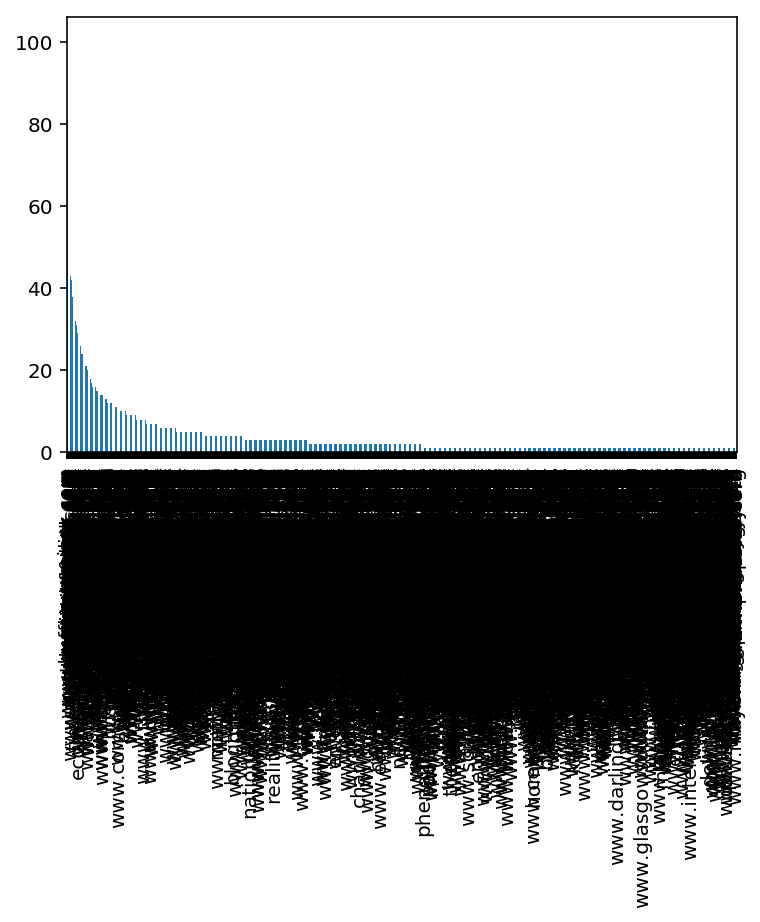

In [7]:
dataset['HOSTNAME'].value_counts().plot(kind="bar")
plt.show()

In [8]:
import re
import string

def clean_text(s):
    s = s.lower()
    for ch in string.punctuation:                                                                                                     
        s = s.replace(ch, " ") 
    s = re.sub("[0-9]+", "||DIG||",s)
    s = re.sub(' +',' ', s)        
    return s

dataset['TEXT'] = [clean_text(s) for s in dataset['TITLE']]

## Naive bayes model

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# pull the data into vectors
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(dataset['TEXT'])

# for Tfidf (we have tried and the results aren't better)
#tfidf = TfidfVectorizer()
#x = tfidf.fit_transform(dataset['TEXT'].values)

encoder = LabelEncoder()
data_china=dataset[(dataset['TITLE'].str.contains('China')) & dataset['CATEGORY'].str.contains('b')]
y = encoder.fit_transform(dataset['CATEGORY'].str.contains('b'))

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# take a look at the shape of each of these
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8000, 8100)
(8000,)
(2000, 8100)
(2000,)


In [79]:
%%time 

nb = MultinomialNB()
nb.fit(x_train, y_train)

Wall time: 7 ms


Let's see cross validation:

In [80]:
%%time

results_nb_cv = cross_val_score(nb, x_train, y_train, cv=10)
print(results_nb_cv.mean())

0.950372949475
Wall time: 110 ms


Test data accuracy is very near to cross validation accuracy which is ok:

In [81]:
nb.score(x_test, y_test)

0.94399999999999995

In [82]:
x_test_pred = nb.predict(x_test)
confusion_matrix(y_test, x_test_pred)

array([[626,   8,   3,  41],
       [  6, 694,   2,   4],
       [ 10,   1, 154,   5],
       [ 24,   4,   4, 414]], dtype=int64)

In [83]:
print(classification_report(y_test, x_test_pred, target_names=encoder.classes_))

             precision    recall  f1-score   support

          b       0.94      0.92      0.93       678
          e       0.98      0.98      0.98       706
          m       0.94      0.91      0.92       170
          t       0.89      0.93      0.91       446

avg / total       0.94      0.94      0.94      2000



Function to predict category from a direct tittle:

In [84]:
def predict_cat(title):
    cat_names = {'b' : 'business', 't' : 'science and technology', 'e' : 'entertainment', 'm' : 'health'}
    cod = nb.predict(vectorizer.transform([title]))
    return cat_names[encoder.inverse_transform(cod)[0]]

In [85]:
predict_cat("hospital the a of for ")

'entertainment'

## Logistic regression model

In [86]:
%%time 

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(x_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(x_test, y_test)))

Accuracy: 0.9555
Wall time: 361 ms


Let's see cross validation accuracy. It took a lot and killed the kernel, so we omit here. The result was very close to the previous test data accuracy

In [87]:
#%%time

#results_clf_cv = cross_val_score(clf, x_train, y_train, cv=10)
#print(results_clf_cv.mean())

In [88]:
x_test_clv_pred = clf.predict(x_test)
confusion_matrix(y_test, x_test_clv_pred)

array([[653,   3,   0,  22],
       [ 11, 691,   1,   3],
       [ 13,   1, 155,   1],
       [ 29,   5,   0, 412]], dtype=int64)

In [89]:
print(classification_report(y_test, x_test_clv_pred, target_names=encoder.classes_))

             precision    recall  f1-score   support

          b       0.92      0.96      0.94       678
          e       0.99      0.98      0.98       706
          m       0.99      0.91      0.95       170
          t       0.94      0.92      0.93       446

avg / total       0.96      0.96      0.96      2000



There is a high correlation between Logistic regression and naive bayes model.

In [90]:
clf_pred = clf.predict(x)
np_pred = nb.predict(x)

models_correlation = np.corrcoef(clf_pred, np_pred)
models_correlation[0,1]

0.93702933646055286

## Conclusion

Naive Bayes and Logistic regression are fast and provide good accuracy.  The faster is Naive Bayes. The best accuracy is obtained with the Logistic Regression model which provides an accuracy of **0.9473** and an average f1-score of **0.95**

## Reference

- [Classifying News Headlines with scikit-learn](https://www.kaggle.com/kinguistics/classifying-news-headlines-with-scikit-learn)

SVM Linear

In [91]:
dataset.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,TEXT
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.394470e+12,fed official says weak data caused by weather ...
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.394470e+12,fed s charles plosser sees high bar for change...
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12,us open stocks fall after fed official hints a...
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12,fed risks falling behind the curve charles plo...
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.394470e+12,fed s plosser nasty weather has curbed job growth


In [92]:
X_raw, y = dataset['TITLE'], dataset['CATEGORY']

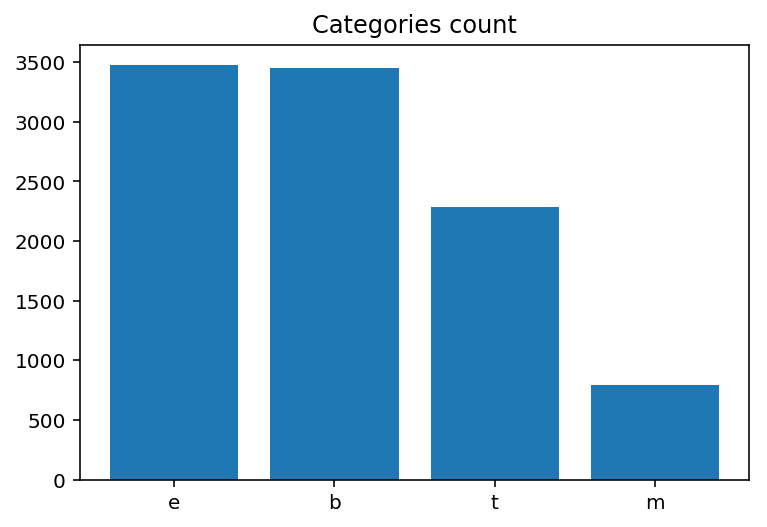

In [93]:
value_counts = dict(y.value_counts())
targets_labels = value_counts.keys()
ind = range(len(targets_labels))
plt.bar(ind, value_counts.values())
plt.title("Categories count")
plt.xticks(ind, targets_labels)
plt.show()

In [94]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X_raw)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [97]:
y_pred = clf.predict(X_test)

In [98]:
print (classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          b       0.91      0.97      0.94       678
          e       0.99      0.98      0.99       695
          m       0.99      0.95      0.97       173
          t       0.95      0.90      0.92       454

avg / total       0.96      0.95      0.95      2000



In [99]:
confusion_matrix(y_test, y_pred)

array([[655,   4,   0,  19],
       [ 12, 681,   1,   1],
       [  6,   1, 165,   1],
       [ 44,   1,   1, 408]], dtype=int64)

In [100]:

accuracy_score(y_test, y_pred)

0.95450000000000002